In [1]:
# GENERICOS
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# DECOMPOSE
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

# TESTS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# MODELOS
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df_base = pd.read_csv('../data/processed/data_processed_1990_2023.csv', index_col='fecha')
df_base.drop('target', axis=1, inplace=True)
df_base.index = pd.to_datetime(df_base.index)
df_base.tail(7)

,tmin,tmax,tmed,presMin,presMax,dir,velmedia,racha,sol,prec
fecha,,,,,,,,,,
2023-03-06,10.3,15.9,13.1,1008.7,1013.4,21.0,1.9,8.3,0.0,3.3
2023-03-07,12.9,19.7,16.3,1009.8,1013.4,22.0,3.9,10.3,3.2,0.6
2023-03-08,14.4,20.5,17.4,1011.6,1015.1,22.0,6.1,10.3,3.2,2.5
2023-03-09,13.6,20.5,17.0,1013.7,1019.5,21.0,5.3,12.5,3.0,0.9
2023-03-10,8.9,21.8,15.4,1019.2,1022.5,99.0,1.7,6.7,10.5,0.1
2023-03-11,8.9,24.0,16.4,1018.7,1022.2,99.0,2.8,7.8,9.9,0.0
2023-03-12,9.5,26.5,18.0,1014.1,1020.3,8.0,2.2,8.3,10.6,0.0


In [3]:
df_last_year = df_base.iloc[-365:]
df_last_year.head()

,tmin,tmax,tmed,presMin,presMax,dir,velmedia,racha,sol,prec
fecha,,,,,,,,,,
2022-03-13,11.0,18.1,14.6,1006.7,1013.8,21.0,1.7,7.8,6.8,12.7
2022-03-14,10.1,14.7,12.4,999.7,1006.7,99.0,4.7,13.9,0.9,1.0
2022-03-15,10.7,16.0,13.4,1002.8,1008.5,7.0,2.8,16.4,0.0,6.4
2022-03-16,11.7,13.5,12.6,1005.8,1012.2,8.0,1.1,9.7,0.0,2.9
2022-03-17,11.1,18.4,14.8,1011.3,1016.7,6.0,3.6,10.3,0.0,0.0


- Trabajamos con TMED

In [4]:
tmed = df_base['tmed']
tmed_last_year = df_last_year['tmed']

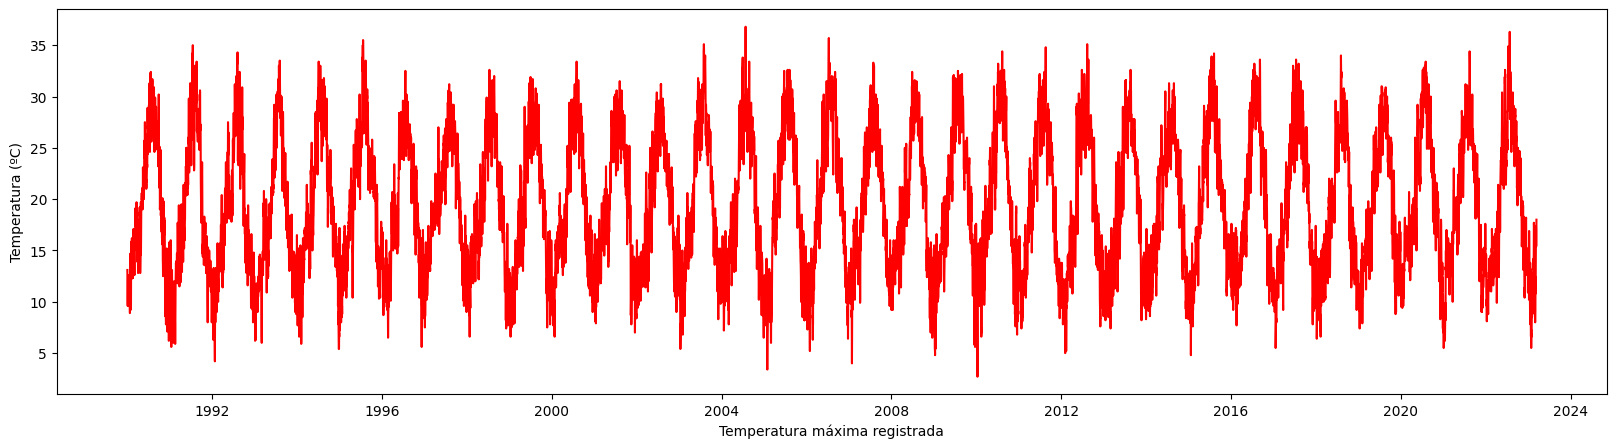

In [5]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(tmed, color='red')
ax.set_xlabel('Temperatura máxima registrada')
ax.set_ylabel('Temperatura (ºC)')
plt.show()

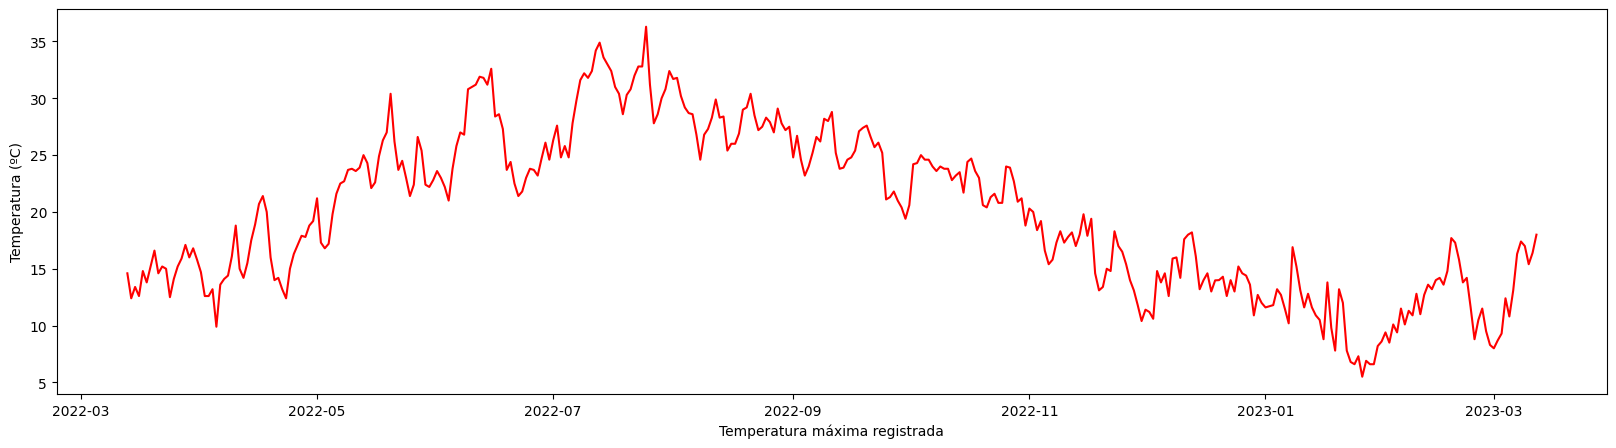

In [6]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(tmed_last_year, color='red')
ax.set_xlabel('Temperatura máxima registrada')
ax.set_ylabel('Temperatura (ºC)')
plt.show()

Veamos la descomposición en los ultimos 365 días para más claridad.

Dado que la magnitud no cambia con el tiempo, usamos la aditiva.

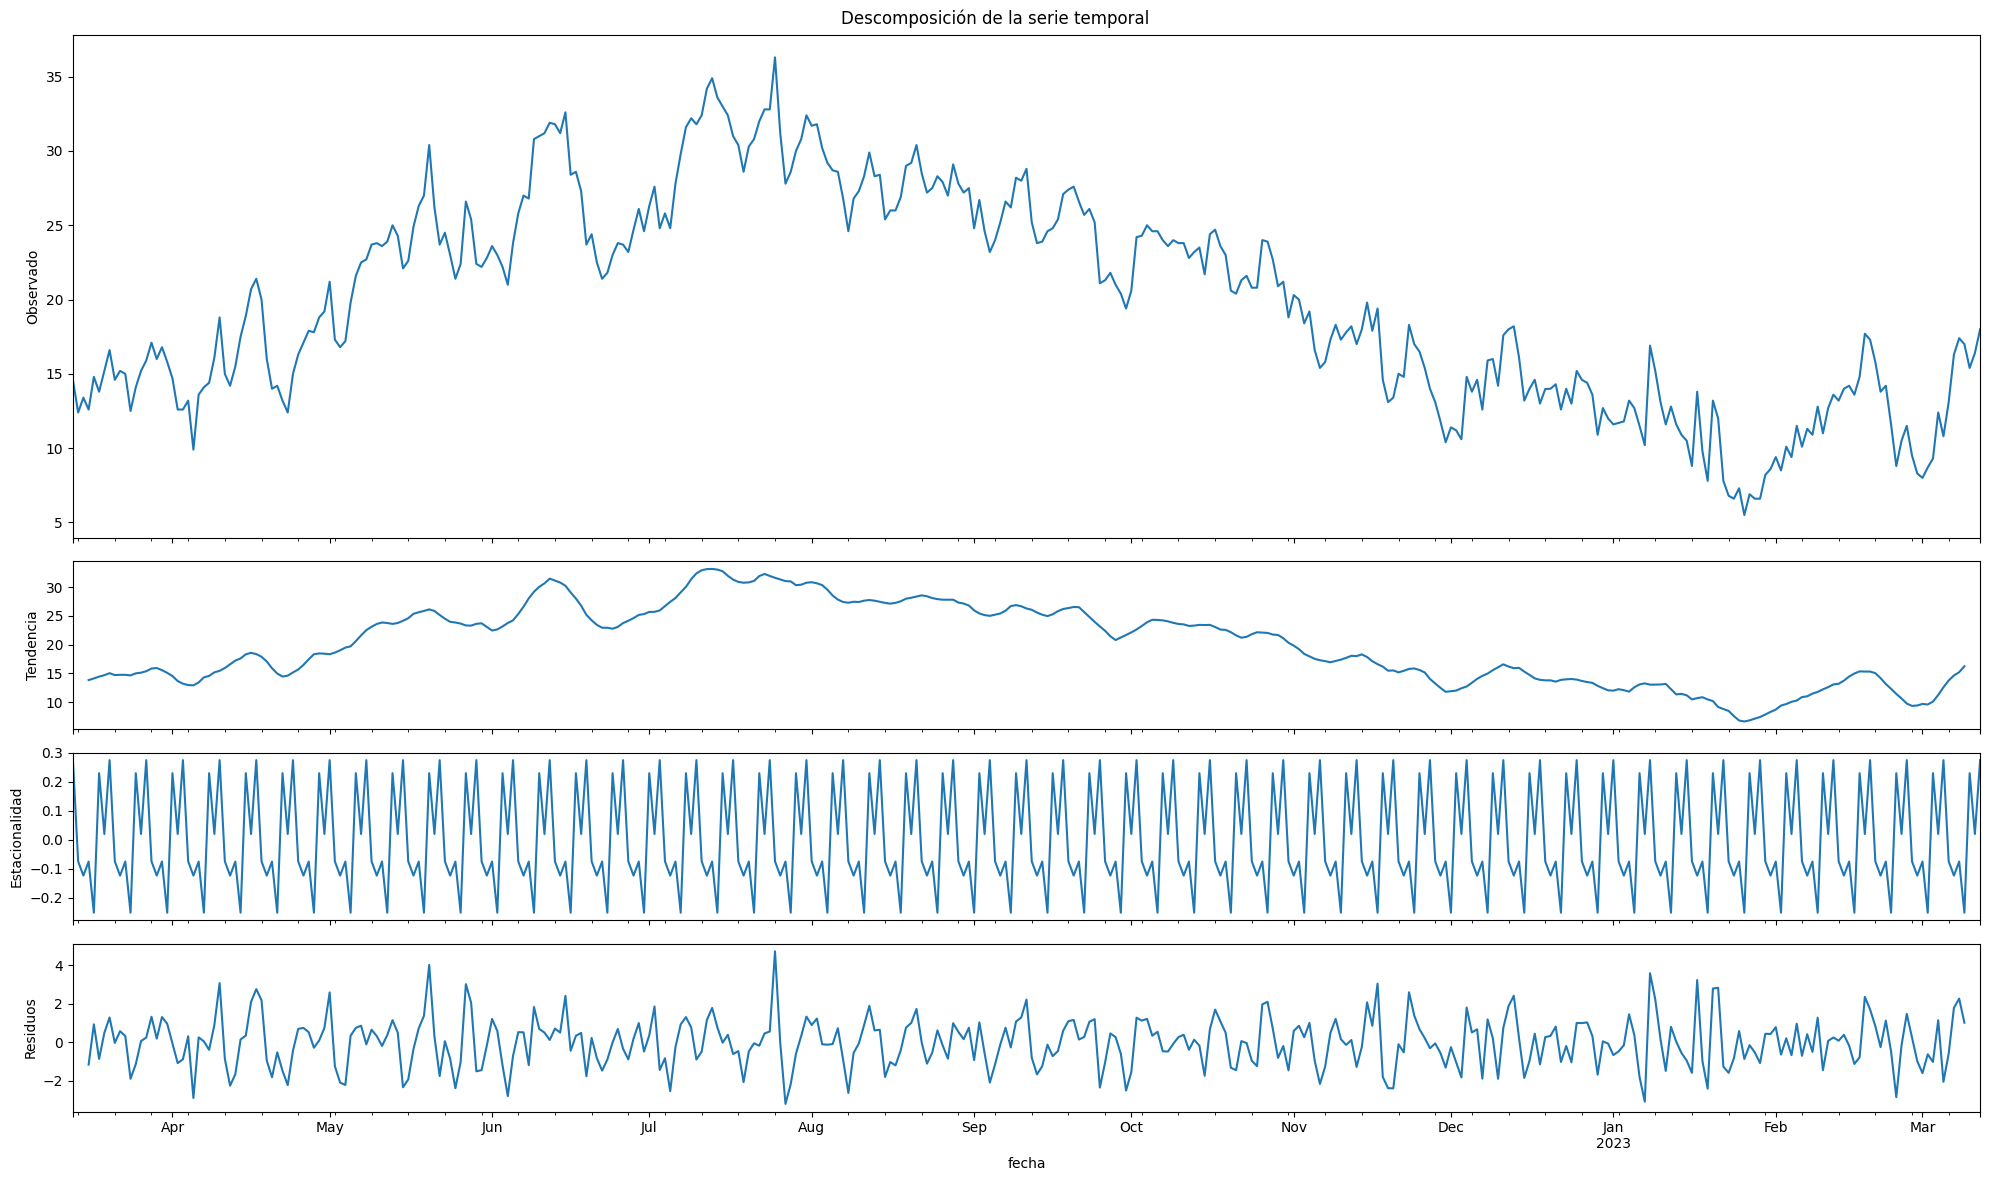

In [7]:
decompose_data = seasonal_decompose(tmed_last_year, model="additive")

# REESCALAR EL PLOT
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

decompose_data.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observado')

decompose_data.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Tendencia')

decompose_data.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Estacionalidad')

decompose_data.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residuos')

fig.suptitle('Descomposición de la serie temporal')

# Ajustar el espaciado entre las subplots
fig.tight_layout()

- No tiene tendencia
- Tiene estacionalidad

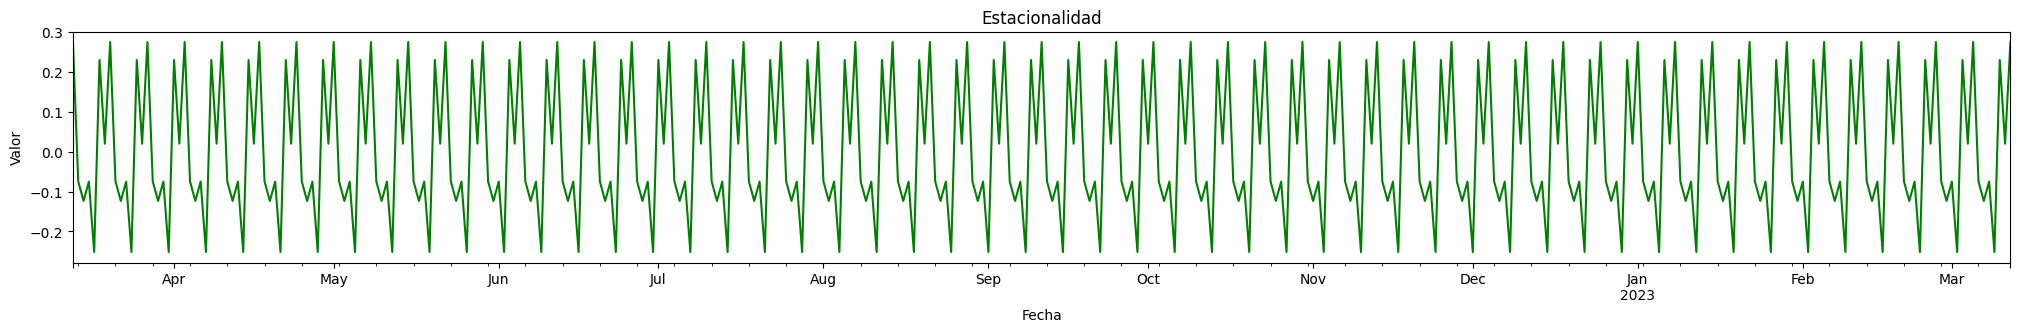

In [8]:
seasonality=decompose_data.seasonal
fig, ax = plt.subplots(figsize=(25, 3))
seasonality.plot(ax=ax, color='green')
ax.set_title('Estacionalidad')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')

# Mostrar el plot
plt.show()

### PRUEBA STL

Al haber un patrón recurrente vamos a probar a un suavizado STL.

In [9]:
stl = STL(tmed_last_year, seasonal=13)
res = stl.fit()

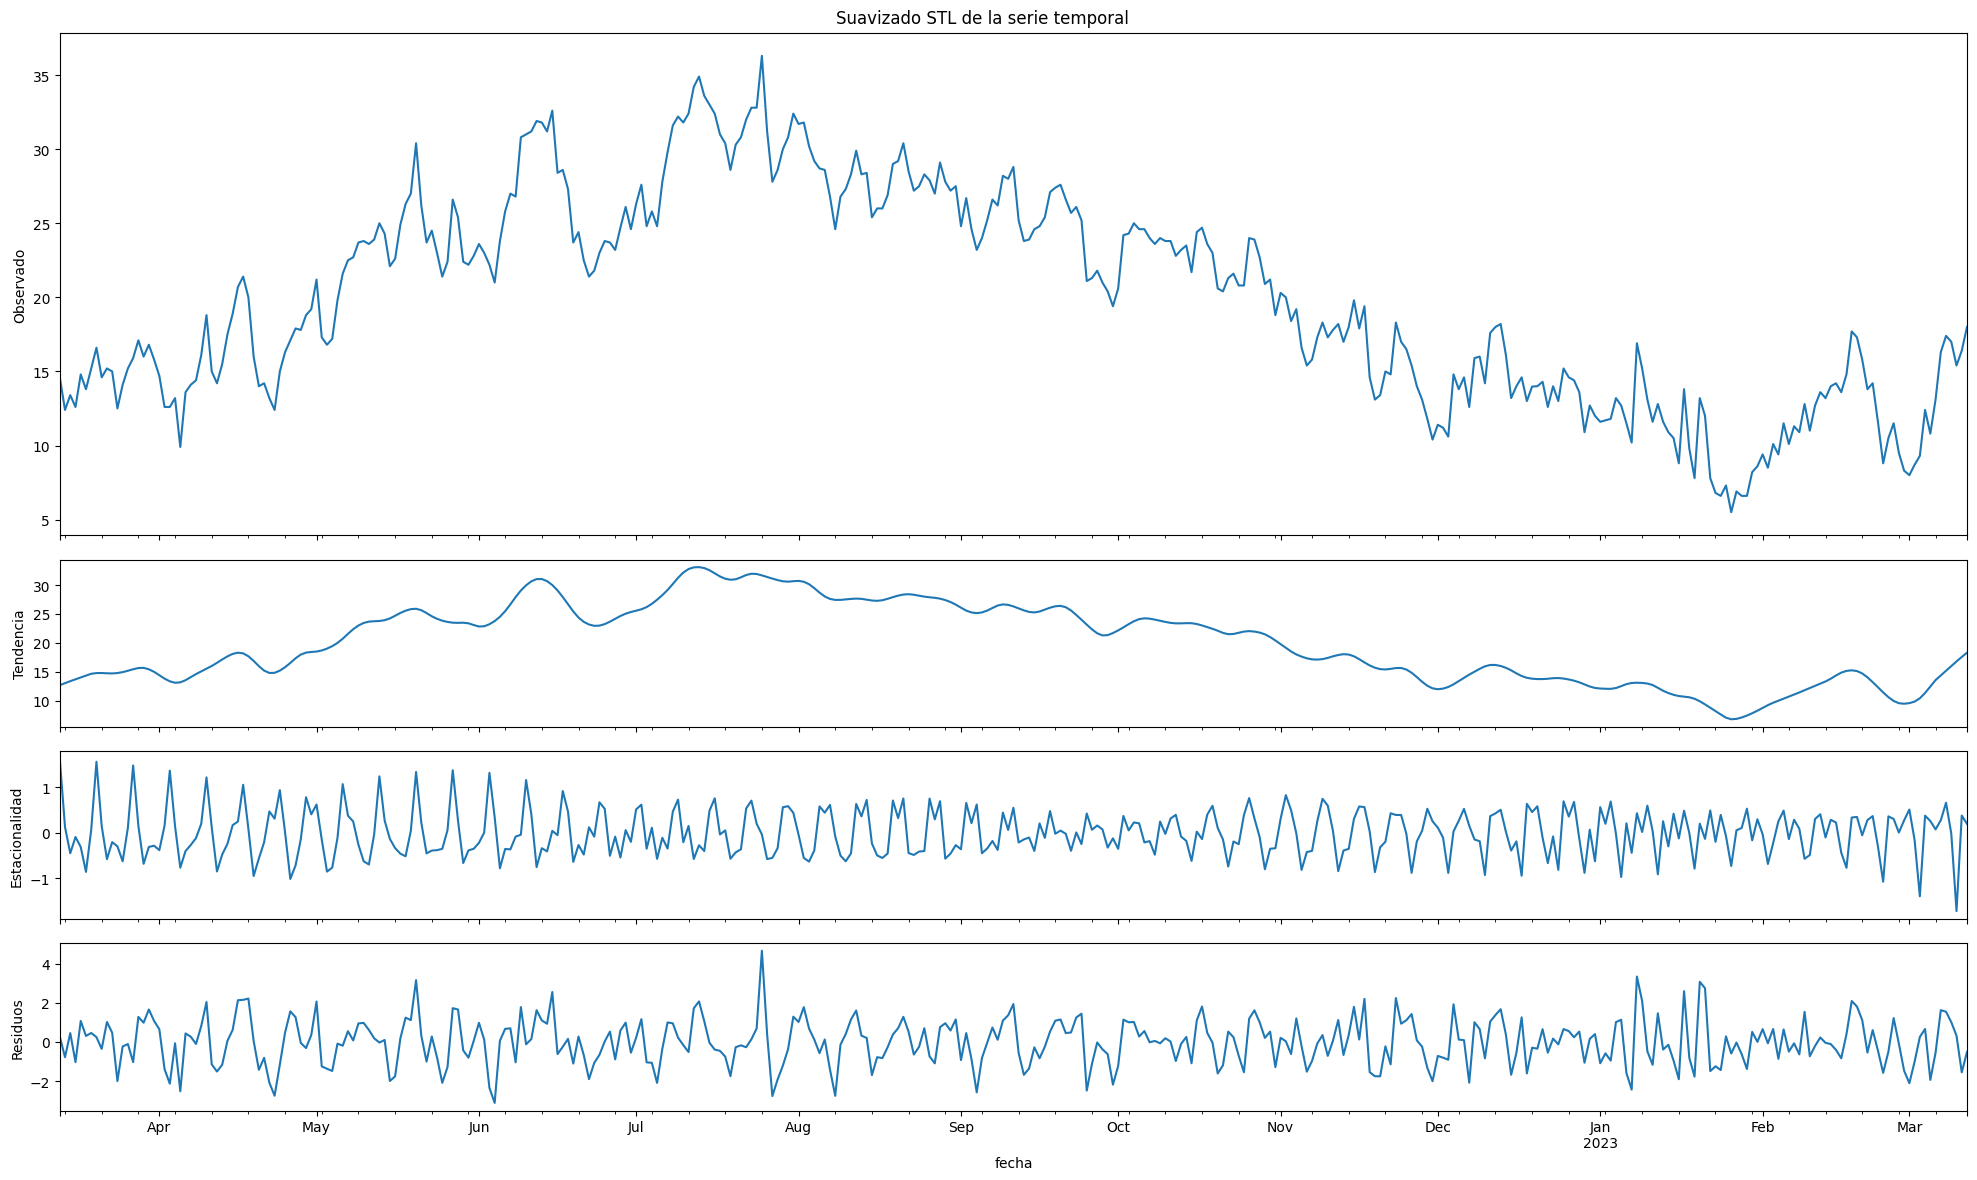

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

res.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observado')


res.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Tendencia')


res.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Estacionalidad')

res.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residuos')

fig.suptitle('Suavizado STL de la serie temporal')

# Ajustar el espaciado entre las subplots
fig.tight_layout()


- Superponemos para comparar

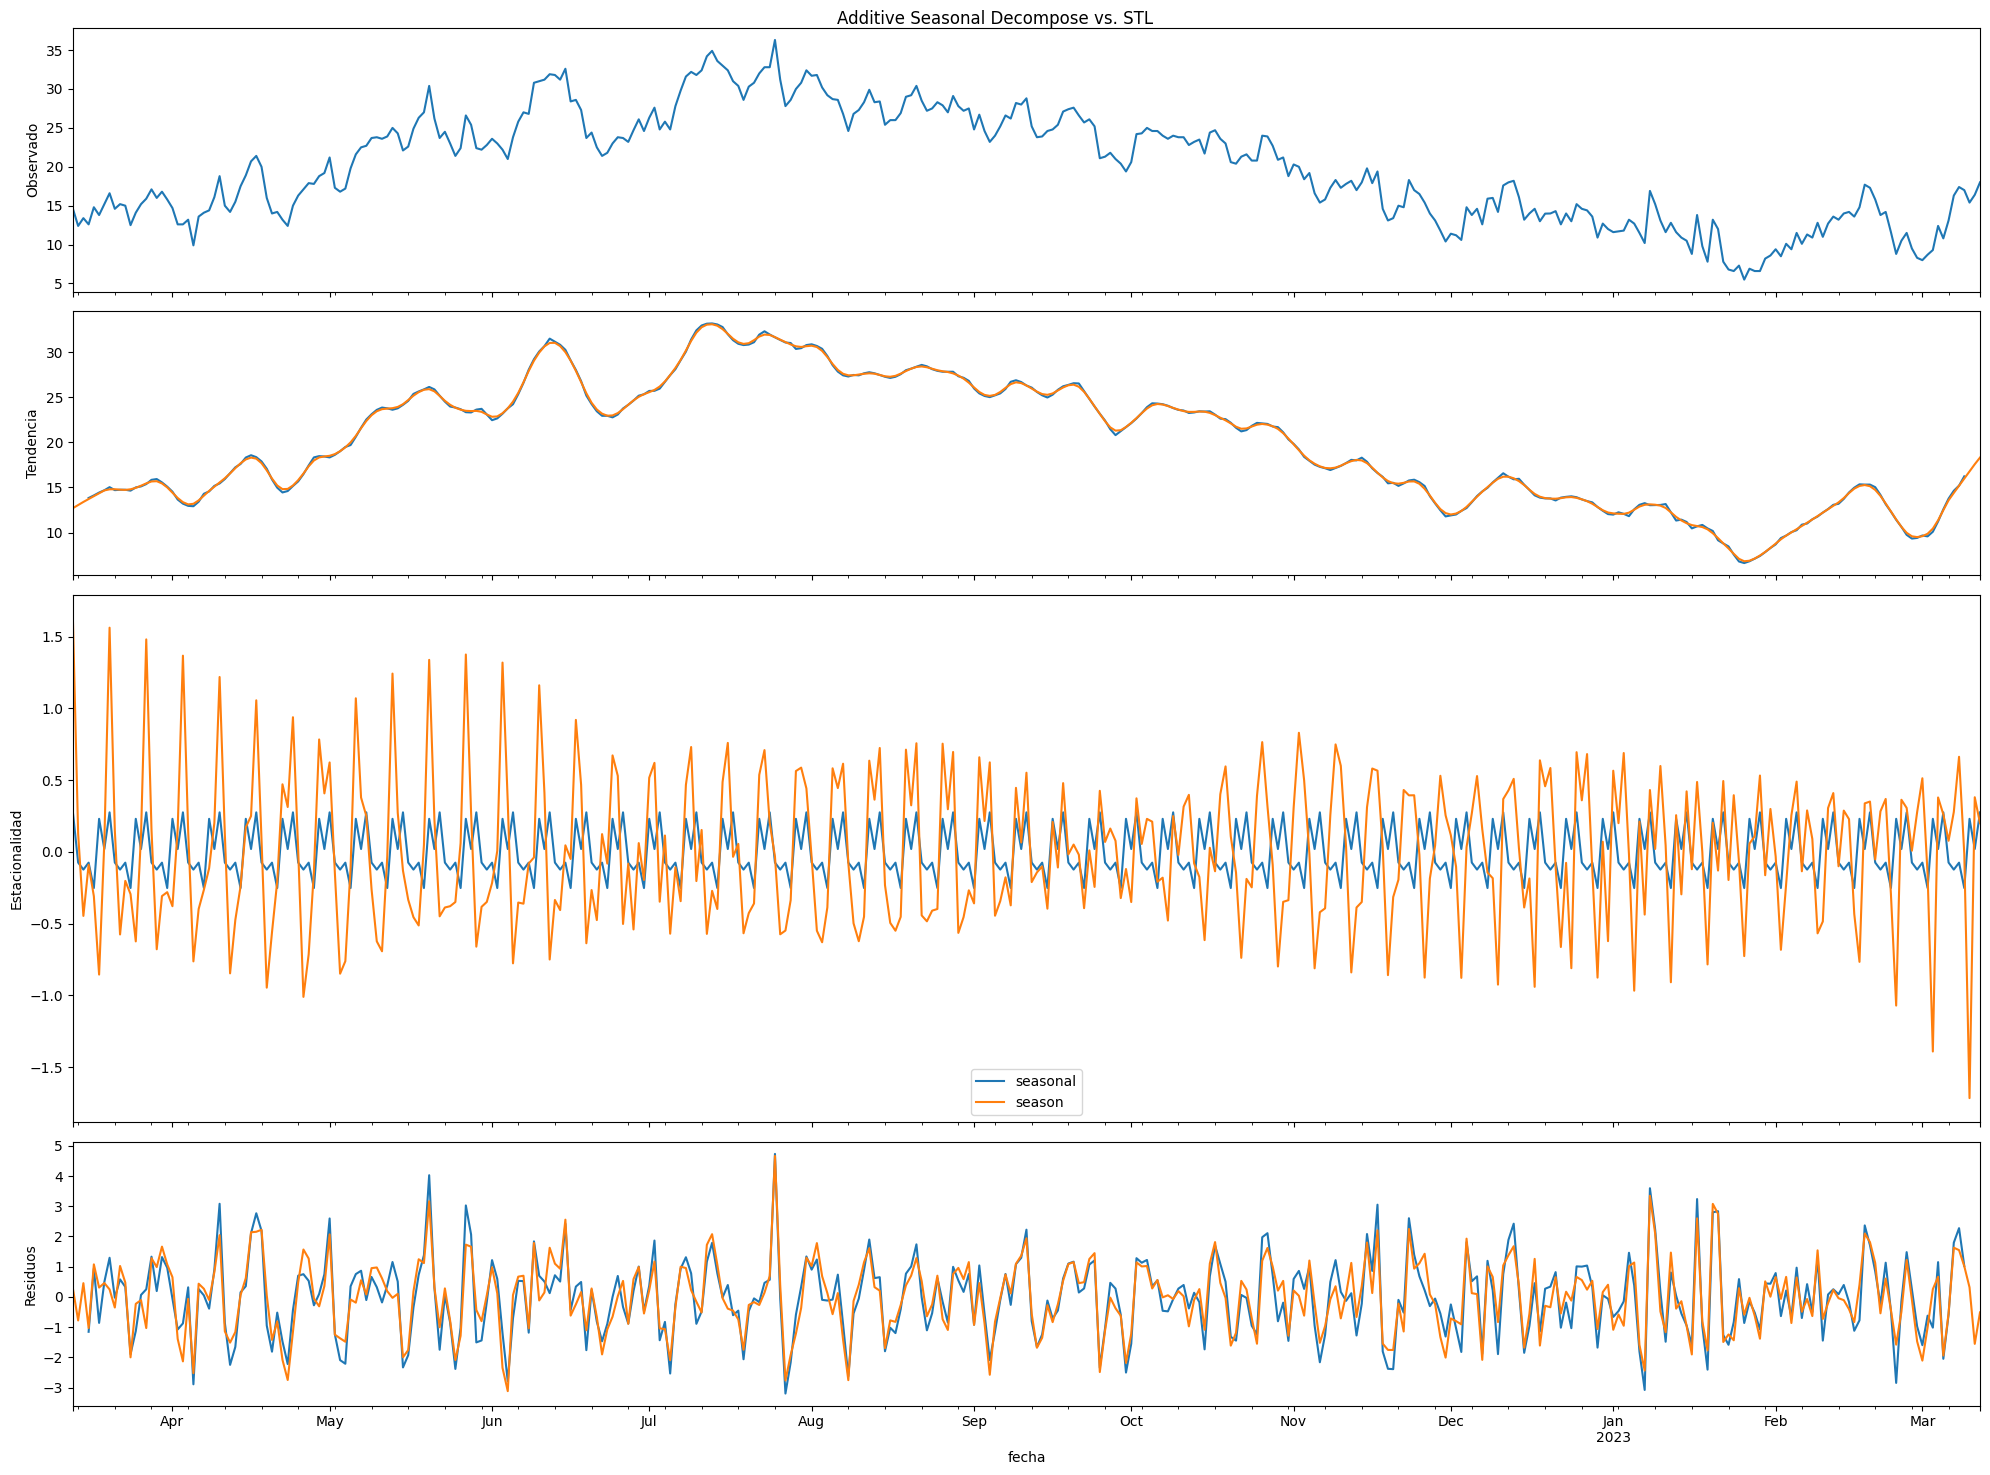

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 15), sharex=True, gridspec_kw={'height_ratios': [1, 1, 2, 1]})

res.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observado')

decompose_data.trend.plot(ax=axes[1], legend=False)
res.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Tendencia')


decompose_data.seasonal.plot(ax=axes[2], legend=False)
res.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Estacionalidad')
axes[2].legend(loc='lower center')

decompose_data.resid.plot(ax=axes[3], legend=False)
res.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residuos')

fig.suptitle('Additive Seasonal Decompose vs. STL')

# Ajustar el espaciado entre las subplots
fig.tight_layout()



ADFULLER

In [12]:
df_adf = adfuller(tmed, autolag = 'AIC')
print("1. ADF : ",df_adf[0])
print("2. P-Value : ", df_adf[1])
print("3. Num Of Lags : ", df_adf[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", df_adf[3])
print("5. Critical Values :")
for key, val in df_adf[4].items():
    print("\t",key, ": ", val)
print(f"Resultado: La serie es {'no' if df_adf[1] > 0.05 else ''}estacionaria")

1. ADF :  -8.594098639880192
2. P-Value :  7.154826175329681e-14
3. Num Of Lags :  40
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 12083
5. Critical Values :
	 1% :  -3.430891313396391
	 5% :  -2.861779232863024
	 10% :  -2.5668973386142
Resultado: La serie es estacionaria


KPSS

In [13]:
df_kpss = kpss(tmed)
print("1. KPSS : ",df_kpss[0])
print("2. P-Value : ", df_kpss[1])
print("3. Num Of Lags : ", df_kpss[2])
print("4. Critical Values :")
for key, val in df_kpss[3].items():
    print("\t",key, ": ", val)
print(f"Resultado: La serie es {'no' if df_kpss[1] < 0.05 else ''}estacionaria")

1. KPSS :  0.02587126548094913
2. P-Value :  0.1
3. Num Of Lags :  67
4. Critical Values :
	 10% :  0.347
	 5% :  0.463
	 2.5% :  0.574
	 1% :  0.739
Resultado: La serie es estacionaria


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


AUTOCORRELATION PLOT

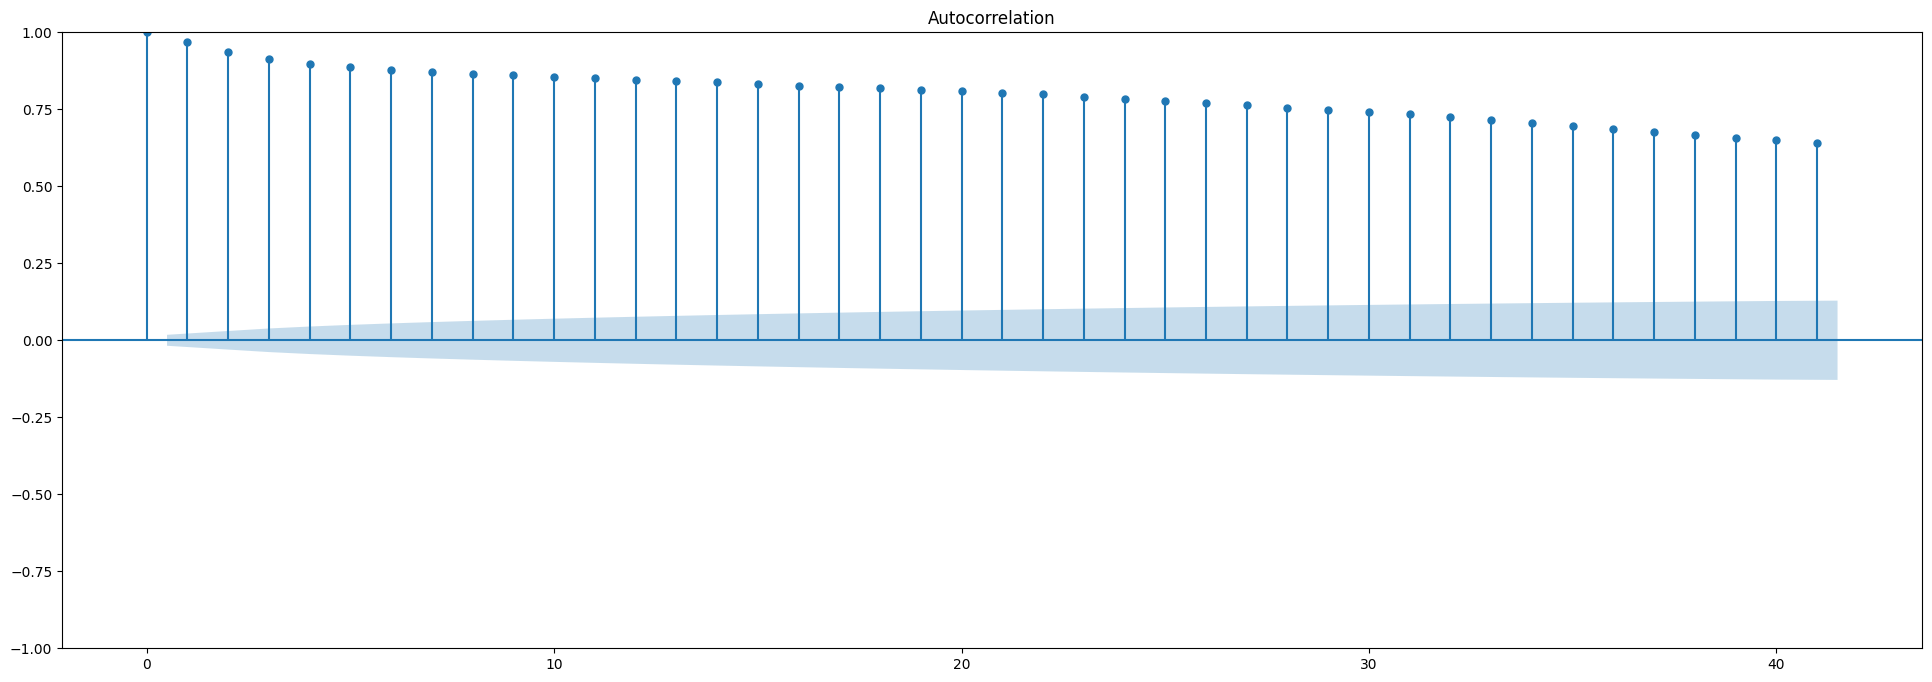

In [14]:
fig, ax = plt.subplots(figsize=(24, 8))
plot_acf(tmed, ax=ax)
plt.show()

C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


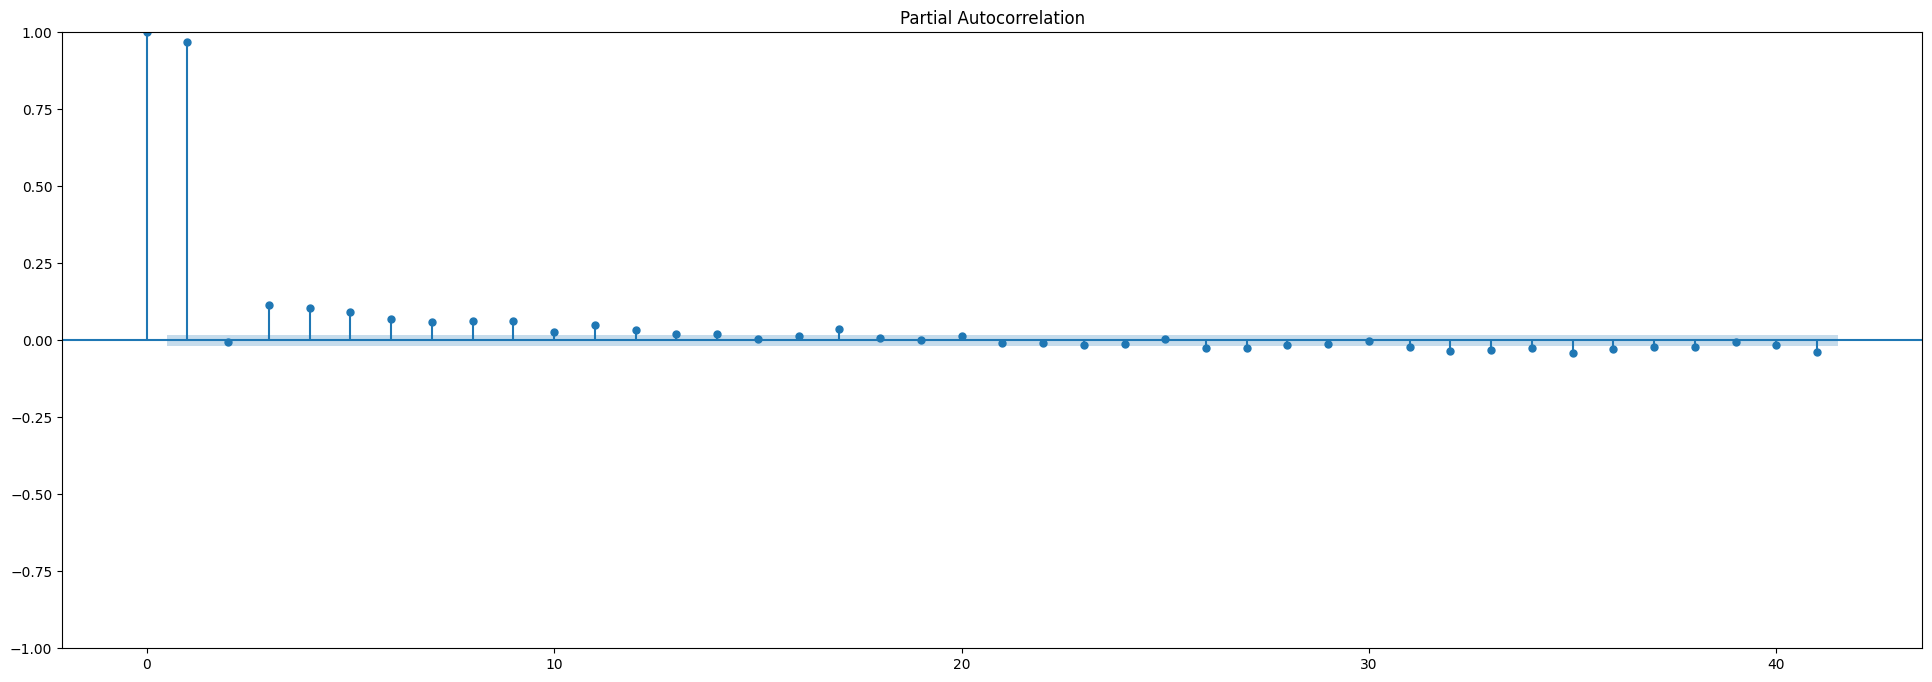

In [15]:
fig, ax = plt.subplots(figsize=(24, 8))
plot_pacf(tmed, ax=ax)
plt.show()

En el PACF vemos que el corte está en el retraso 3, con lo que su valor de `p` será = 2.

SEASONAL (ACF)

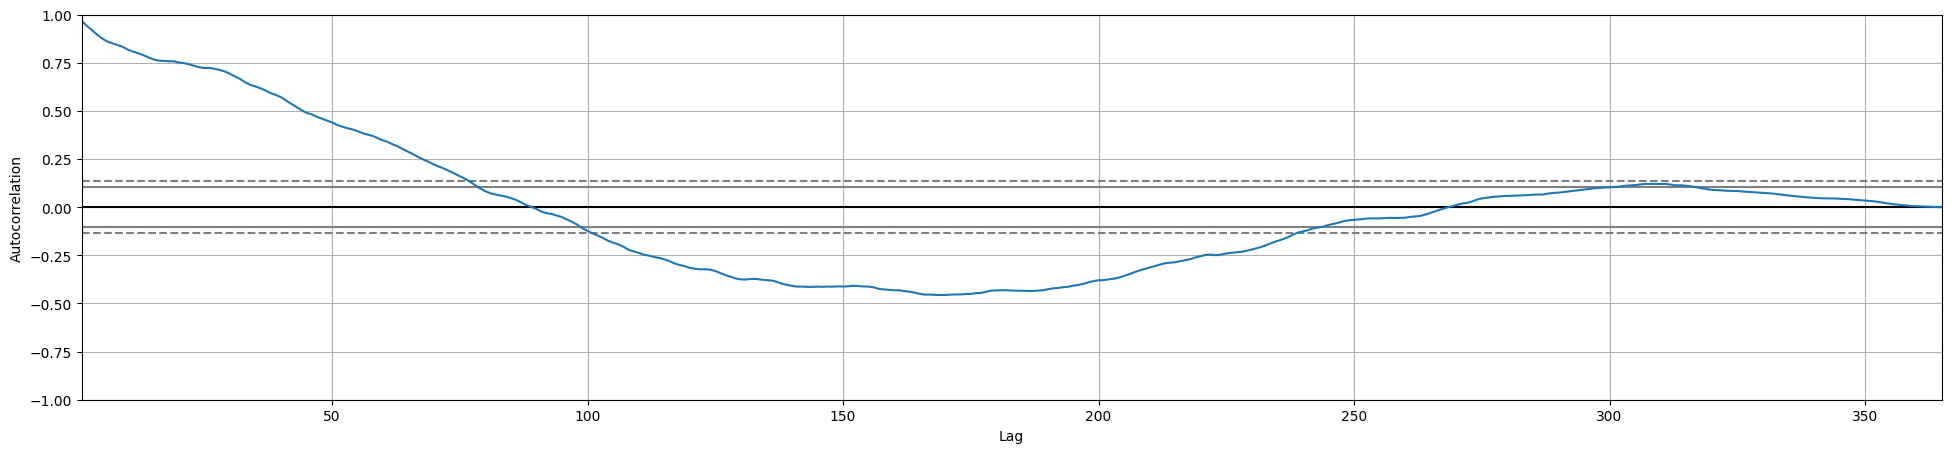

In [16]:
fig, ax = plt.subplots(figsize=(24, 5))
x = pd.plotting.autocorrelation_plot(tmed_last_year)
x.plot()
plt.show()

MA

In [17]:
q_values = range(1, 6)
d_values = range(3)

best_aic = float("inf")
best_params = None

tmed.index.freq = tmed.index.inferred_freq
for q, d in itertools.product(q_values, d_values):
    try:
        model = ARIMA(tmed, order=(q, d, 2))
        resultados_ma = model.fit()
        aic = resultados_ma.aic
        print(q,d,aic)
        
        if aic < best_aic:
            best_aic = aic
            best_params = (q, d)
            
    except:
        continue
        
print("Los valores óptimos de q y d son:", best_params)

1 0 46777.665154352304
1 1 46397.0544662972
1 2 46583.33279174476


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 0 46377.717295175324
2 1 46382.002450756525


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 2 46394.88873075745


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3 0 46274.98998327883
3 1 46387.86188686975
3 2 46987.22270357954


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4 0 46132.38208792453
4 1 46385.478403203015


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4 2 46462.3331723054


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


5 0 46358.907494917854
5 1 46387.25620594606


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


5 2 46701.69941711594
Los valores óptimos de q y d son: (4, 0)


In [18]:
predicciones_ma = resultados_ma.predict(start=len(tmed)-7, end=len(tmed)-1)

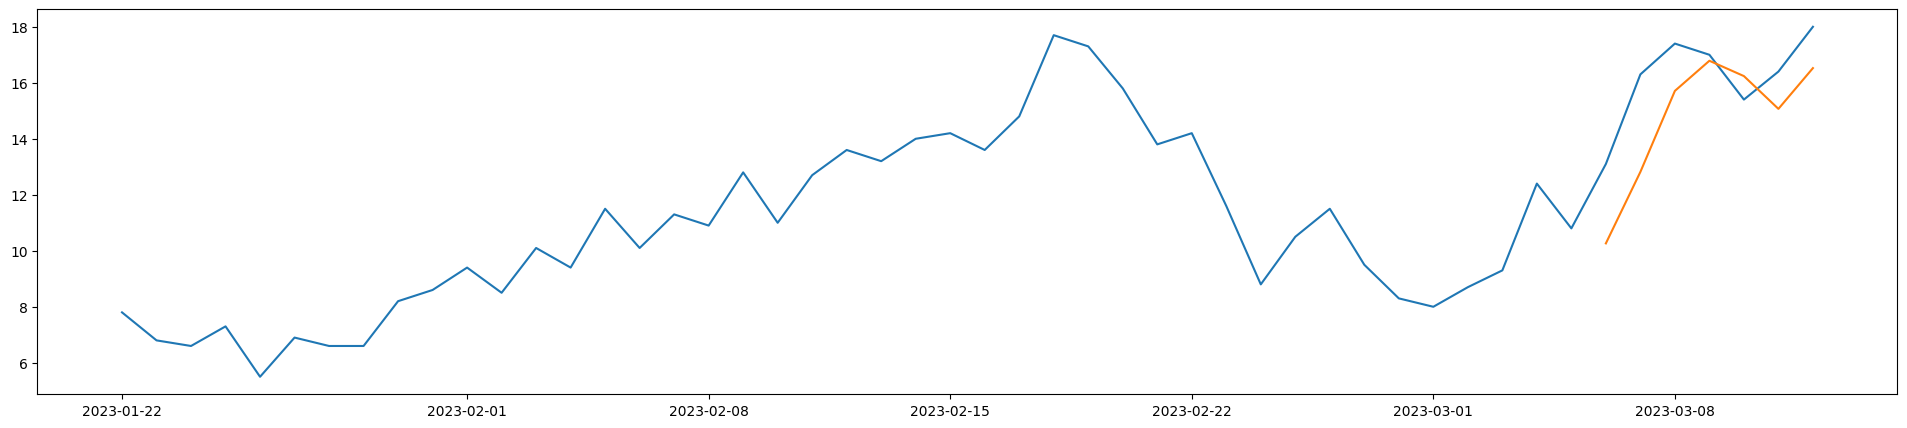

In [19]:
plt.subplots(figsize=(24, 5))
plt.plot(tmed[-50:])
plt.plot(predicciones_ma)
plt.show()

No vale porque está haciendo lo mismo que el día anterior

ARIMA + STL

Usamos MSE para darle más peso a errores grandes

Iteration 1: p=1, d=0, q=1, MSE=36.39460659399741
Iteration 2: p=1, d=1, q=1, MSE=24.03242495341116
Iteration 3: p=1, d=0, q=2, MSE=34.921604216915306
Iteration 4: p=1, d=1, q=2, MSE=23.307545928230304
Iteration 5: p=1, d=0, q=3, MSE=34.55355021944316
Iteration 6: p=1, d=1, q=3, MSE=23.329995414648774
Iteration 7: p=1, d=0, q=4, MSE=32.11968425202468
Iteration 8: p=1, d=1, q=4, MSE=23.21783743115414


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 9: p=1, d=0, q=5, MSE=17.132574396645648


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 10: p=1, d=1, q=5, MSE=21.38733315199739


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 11: p=2, d=0, q=1, MSE=35.020107309171756
Iteration 12: p=2, d=1, q=1, MSE=23.14324825939066


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 13: p=2, d=0, q=2, MSE=28.66457813573108


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 14: p=2, d=1, q=2, MSE=24.387156066262957
Iteration 15: p=2, d=0, q=3, MSE=34.69105955323741


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration 16: p=2, d=1, q=3, MSE=22.947006036498742


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 17: p=2, d=0, q=4, MSE=31.65435634957132


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 18: p=2, d=1, q=4, MSE=27.233652486798533


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 19: p=2, d=0, q=5, MSE=18.732656787945288


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 20: p=2, d=1, q=5, MSE=16.7246417897728


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 21: p=3, d=0, q=1, MSE=35.2965701567293
Iteration 22: p=3, d=1, q=1, MSE=23.305520880353857


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 23: p=3, d=0, q=2, MSE=26.700444079514764


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration 24: p=3, d=1, q=2, MSE=22.842224030033744


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 25: p=3, d=0, q=3, MSE=34.00642094148843


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 26: p=3, d=1, q=3, MSE=20.832161644810427


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 27: p=3, d=0, q=4, MSE=31.879209476867736


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 28: p=3, d=1, q=4, MSE=22.05508379803387


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 29: p=3, d=0, q=5, MSE=21.537147844295774


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 30: p=3, d=1, q=5, MSE=22.023620240480355


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 31: p=4, d=0, q=1, MSE=34.13959944498579
Iteration 32: p=4, d=1, q=1, MSE=31.499077263047923


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 33: p=4, d=0, q=2, MSE=19.400983119644653


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration 34: p=4, d=1, q=2, MSE=23.700295689269204


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 35: p=4, d=0, q=3, MSE=29.868932415164807


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 36: p=4, d=1, q=3, MSE=20.967642497828294


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 37: p=4, d=0, q=4, MSE=23.80371245783291


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 38: p=4, d=1, q=4, MSE=20.858296116452788


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 39: p=4, d=0, q=5, MSE=22.640890745384645


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 40: p=4, d=1, q=5, MSE=22.51181327064769
Iteration 41: p=5, d=0, q=1, MSE=34.94235429662845
Iteration 42: p=5, d=1, q=1, MSE=31.621584517344395


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 43: p=5, d=0, q=2, MSE=29.84602398489258
Iteration 44: p=5, d=1, q=2, MSE=21.257585225818012


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 45: p=5, d=0, q=3, MSE=33.048617687268994


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 46: p=5, d=1, q=3, MSE=27.65548112497205


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 47: p=5, d=0, q=4, MSE=25.563251212404477


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 48: p=5, d=1, q=4, MSE=23.581350932938612


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 49: p=5, d=0, q=5, MSE=27.206967391958397


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 50: p=5, d=1, q=5, MSE=28.658896487039474
Best MSE: 16.7246417897728
Best Parameters: (2, 1, 5)


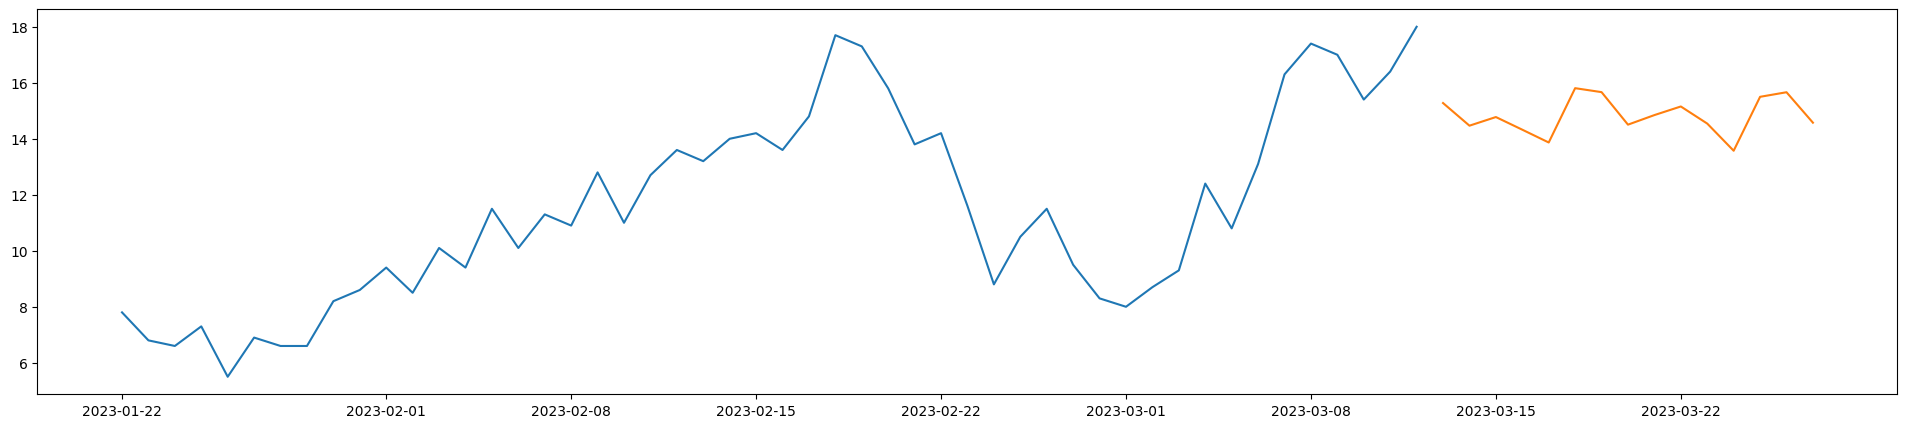

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                12124
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -19152.751
Date:                Fri, 17 Mar 2023   AIC                          38329.501
Time:                        14:34:00   BIC                          38418.336
Sample:                    01-01-1990   HQIC                         38359.286
                         - 03-12-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0010      0.002     -0.505      0.613      -0.005       0.003
ar.L1          0.2012      0.009     23.076      0.000       0.184       0.218
ar.L2         -0.9574      0.009   -106.091      0.0

In [20]:
from statsmodels.tsa.forecasting.stl import STLForecast
from sklearn.metrics import mean_squared_error
import itertools

p_values = range(1, 6)
q_values = range(1, 6)
d_values = range(3)

best_mse = float("inf")
best_params = None
best_forecast = None

tmed.index.freq = tmed.index.inferred_freq
iteration = 0

for p, q, d in itertools.product(p_values, q_values, d_values):
    try:
        stlf = STLForecast(
            tmed, ARIMA, model_kwargs=dict(order=(p, d, q), trend="t")
        )
        stlf_res = stlf.fit()
        mse = mean_squared_error(tmed[-15:], stlf_res.forecast(15))
        iteration += 1
        print(f"Iteration {iteration}: p={p}, d={d}, q={q}, MSE={mse}")
        if mse < best_mse:
            best_mse = mse
            best_params = (p, d, q)
            best_forecast = stlf_res.forecast(15)
    except:
        continue

print(f"Best MSE: {best_mse}")
print(f"Best Parameters: {best_params}")

plt.subplots(figsize=(24, 5))
plt.plot(tmed[-50:])
plt.plot(best_forecast)
plt.show()
print(stlf_res.summary())


------